# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [0]:
#1 write a function

def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, iterations = 1):
  i = 0
  while i <= iterations:
    #true positive rate: 100%
    p_pos_drunk = 1
    #prior probability
    p_drunk = prob_drunk_prior
    #false positive rate: 1%
    p_pos_notdrunk = false_positive_rate
    #prior probabilty (compliment of p_user)
    p_notdrunk = 1 - p_drunk

    #apply Baye's Theorem
    p_drunk_pos = (p_pos_drunk*p_drunk)/(p_pos_drunk*p_drunk+ p_pos_notdrunk*p_notdrunk)
    prob_drunk_prior = p_drunk_pos
    i+=1
  return p_drunk_pos

In [36]:
print('Result after 1 iteration: {}'.format(prob_drunk_given_positive(1/1000, 0.08)))
print('Result after 2 iterations: {}'.format(prob_drunk_given_positive(1/1000, 0.08, iterations=2)))

Result after 1 iteration: 0.13525210993291495
Result after 2 iterations: 0.6615996951348605


Result after 1 iteration(s): 0.13525
Result after 2 iteration(s): 0.66160
Result after 3 iteration(s): 0.96069
Result after 4 iteration(s): 0.99674
Result after 5 iteration(s): 0.99974


Text(0.5, 1.0, 'Bayesian Statistics Tests')

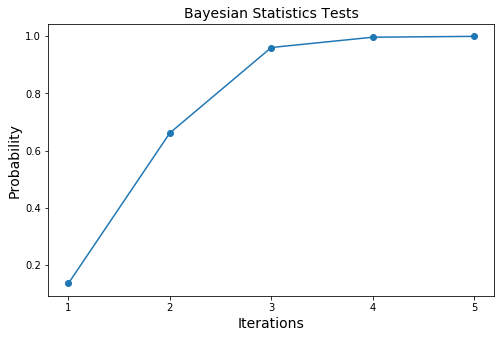

In [50]:
import matplotlib.pyplot as plt
iterations = range(1,6)
y = []
for iteration in iterations:
  result = prob_drunk_given_positive(1/1000, 0.08, iterations=iteration)
  y.append(result)
  print('Result after {} iteration(s): {:.5f}'.format(iteration, result))

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(iterations, y, marker='o');
ax.set_ylabel("Probability", fontsize=14)
ax.set_xlabel("Iterations", fontsize=14)
ax.set_xticks(iterations);
ax.set_title("Bayesian Statistics Tests", fontsize=14)

After only 3 positive tests, the probability of a person being drunk is already greater than 95%. By the 3rd test, the probability that the person is drunk is 96%. 

In [51]:
#comparing frequentists and bayesian statistics
#we will use the voting dataset
import pandas as pd
import numpy as np
#load data
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', 
                 names=['party', 'handicapped-infants', 'water-project', 
                  'budget', 'physician-fee-freeze', 'el-salvador-aid', 'religious-groups', 
                  'anti-satellite-ban', 'aid-to-contras', 'mx-missile', 'immigration', 
                  'synfuels', 'education', 'right-to-sue', 'crime', 'duty-free', 
                  'south-africa'])
df = df.replace({'?':np.nan, 'y':1, 'n':0})
print(df.head())
df.describe()

        party  handicapped-infants  ...  duty-free  south-africa
0  republican                  0.0  ...        0.0           1.0
1  republican                  0.0  ...        0.0           NaN
2    democrat                  NaN  ...        0.0           0.0
3    democrat                  0.0  ...        0.0           1.0
4    democrat                  1.0  ...        1.0           1.0

[5 rows x 17 columns]


,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
count,423.000000,387.000000,424.000000,424.000000,420.000000,424.000000,421.000000,420.00000,413.000000,428.000000,414.000000,404.000000,410.000000,418.000000,407.000000,331.000000
mean,0.442080,0.503876,0.596698,0.417453,0.504762,0.641509,0.567696,0.57619,0.501211,0.504673,0.362319,0.423267,0.509756,0.593301,0.427518,0.812689
std,0.497222,0.500632,0.491140,0.493721,0.500574,0.480124,0.495985,0.49475,0.500605,0.500563,0.481252,0.494690,0.500516,0.491806,0.495327,0.390752
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [70]:
import scipy.stats as stats
import numpy as np
filtered_df = df[df['religious-groups'].notnull()]
data = df['religious-groups']
bayesian_confidence_interval, _, _ = stats.bayes_mvs(np.array(data), alpha=0.95)
print(bayesian_confidence_interval)
data.count_values()

Mean(statistic=nan, minmax=(nan, nan))


AttributeError: ignored

In [55]:
data

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
430    1.0
431    0.0
432    1.0
433    1.0
434    1.0
Name: religious-groups, Length: 435, dtype: float64

In [0]:
# 95% confidence interval
t_stat = t.ppf(.975, dof)
print("t Statistic:", t_stat)

CI = (mean-(t_stat*std_err), mean+(t_stat*std_err))
print("Confidence Interval", CI)

The difference between Frequentist statistics and Bayesian statistics is that frequentists start with an assumption of the distibution of the population before making inferences based on a sample. Bayesian statistics don't predescribe a distribution. Instead, it only uses already known information to make a prediction about a population. 

## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!